In [28]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SimpleRNN, GRU
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import os


# Арешин С.О. М8О-304Б-17 Вариант 1. Генерация прозы на русском языке, элемент последовательности - один символ.

# Подготовка датасета

In [2]:
# подразумевается счачивать несколько книг, но сеть даже на одной книге (она довольно таки большая) долго обучается

# книга
books = ['abramov_dom.txt'] 

# ссылка
links = ['http://lib.ru/PROZA/ABRAMOW/abramov_dom.txt']


# функция считвания текста из файлов

def text_from_file(filepath):
    text = ""
    with open(filepath, 'rb') as book:
        text = book.read().decode(encoding='koi8-r')
    return text

In [3]:
# скачиваем текста книг с помощью get_file и считываем его  с помощью text_from_file

raw_text = ''
for book, link in zip(books, links):
    filepath = tf.keras.utils.get_file(book, link)
    raw_text += text_from_file(filepath)[766:-150] # очитска книги от шапок в начале и конце

# переведём текст в нижних регистр чтобы уменьшить словарный запас    
raw_text = raw_text.lower()
len(raw_text)

491449

In [4]:
# создадим словарь уникальных символов
vocabulary = sorted(list(set(raw_text)))

# преобразуем уникальные символы в числа
char2idx = {u:i for i, u in enumerate(vocabulary)}

# обратное преобразование
idx2char = np.array(vocabulary)

# преобразуем текст из символов в числа
text_to_int = np.array([char2idx[c] for c in raw_text])


In [5]:
# количество символов всего
n_chars = len(raw_text)

# количество символов в словаре
n_vocab = len(vocabulary)

print ('Всего символов: ', n_chars)
print ('Всего слов в словаре: ', n_vocab)

Всего символов:  491449
Всего слов в словаре:  68


In [6]:
# подготовка датасета

seq_length = 100 # последовательности длиной seq_length 
examples_per_epoch =  len(raw_text)//(seq_length+1) 


char_dataset = tf.data.Dataset.from_tensor_slices(text_to_int)

# последовательности токенов
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [7]:
# созданим метку для предсказания следующей буквы

def split_input_target(part):
    input_text = part[:-1]
    target_text = part[1:]
    return input_text, target_text

data = sequences.map(split_input_target)

In [8]:
# зашафлим данные и разобъем на батчи

data = data.shuffle(10000).batch(64, drop_remainder=True)

# Однослойная LSTM

In [9]:
batch_size = 64
num_epochs = 60

In [10]:
# функция потерь

def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [11]:
# односйлойная сеть LSTM 

lstm_sing =  Sequential([
                         Embedding(n_vocab, 256,
                                   batch_input_shape=[batch_size, None]),
                         LSTM(1024,
                              return_sequences=True,
                              stateful=True,
                              recurrent_initializer='glorot_uniform'),
                         Dense(n_vocab)
                         ])
lstm_sing.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           17408     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 68)            69700     
Total params: 5,334,084
Trainable params: 5,334,084
Non-trainable params: 0
_________________________________________________________________


In [12]:
#cкомпилируем модель

lstm_sing.compile(loss= loss, optimizer='adam')

In [13]:
# создадим чекпоинты

lstm_sing_dir = './lstm1_checkpoints'
lstm_sing_prefix = os.path.join(lstm_sing_dir, "checkpoint_{epoch}")
lstm_sing_checkpoint = ModelCheckpoint(filepath=lstm_sing_prefix, save_weights_only=True)

In [14]:
# обучим модель

lstm_one = lstm_sing.fit(data, epochs=num_epochs,callbacks=[lstm_sing_checkpoint])

Epoch 1/60
76/76 [==============================] - 13s 167ms/step - loss: 3.0781
Epoch 2/60
76/76 [==============================] - 13s 166ms/step - loss: 2.5060
Epoch 3/60
76/76 [==============================] - 13s 167ms/step - loss: 2.2829
Epoch 4/60
76/76 [==============================] - 13s 166ms/step - loss: 2.1146
Epoch 5/60
76/76 [==============================] - 13s 166ms/step - loss: 1.9966
Epoch 6/60
76/76 [==============================] - 13s 167ms/step - loss: 1.8923
Epoch 7/60
76/76 [==============================] - 13s 167ms/step - loss: 1.8036
Epoch 8/60
76/76 [==============================] - 13s 166ms/step - loss: 1.7254
Epoch 9/60
76/76 [==============================] - 13s 167ms/step - loss: 1.6579
Epoch 10/60
76/76 [==============================] - 13s 167ms/step - loss: 1.5983
Epoch 11/60
76/76 [==============================] - 13s 167ms/step - loss: 1.5420
Epoch 12/60
76/76 [==============================] - 13s 166ms/step - loss: 1.4880
Epoch 13/60
7

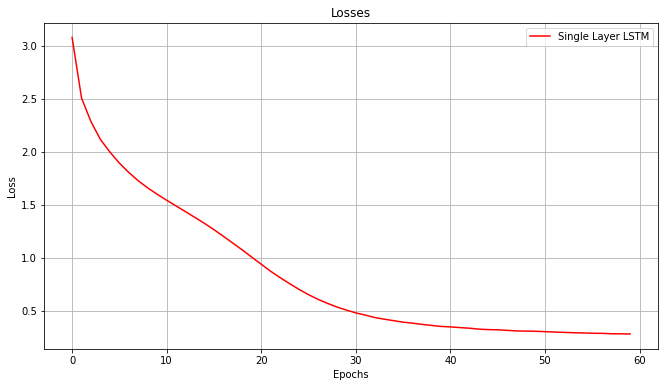

In [20]:
# построим график функции потерь

plt.figure(figsize=[11,6])
plt.plot(lstm_one.history['loss'], 'r')
plt.grid()
plt.title('Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Single Layer LSTM'], loc='upper right')   

# Двухслойная LSTM

In [21]:
# двухслойная сеть LSTM 

lstm_double =  Sequential([
                         Embedding(n_vocab, 256,
                                   batch_input_shape=[batch_size, None]),
                         LSTM(1024,
                              return_sequences=True,
                              stateful=True,
                              recurrent_initializer='glorot_uniform'),
                         LSTM(1024,
                              return_sequences=True,
                              stateful=True,
                              recurrent_initializer='glorot_uniform'),
                         Dense(n_vocab)
                         ])
lstm_double.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (64, None, 256)           17408     
_________________________________________________________________
lstm_1 (LSTM)                (64, None, 1024)          5246976   
_________________________________________________________________
lstm_2 (LSTM)                (64, None, 1024)          8392704   
_________________________________________________________________
dense_1 (Dense)              (64, None, 68)            69700     
Total params: 13,726,788
Trainable params: 13,726,788
Non-trainable params: 0
_________________________________________________________________


In [22]:
# cкомпилируем модель

lstm_double.compile(loss= loss, optimizer='adam')

In [23]:
# создадим чекпоинты

lstm_double_dir = './lstm2_checkpoints'
lstm_double_prefix = os.path.join(lstm_double_dir, "checkpoint_{epoch}")
lstm_double_checkpoint = ModelCheckpoint(filepath=lstm_double_prefix, save_weights_only=True)

In [24]:
# обучим модель

lstm_two = lstm_double.fit(data, epochs=num_epochs,callbacks=[lstm_double_checkpoint])

Epoch 1/60
76/76 [==============================] - 29s 381ms/step - loss: 3.1806
Epoch 2/60
76/76 [==============================] - 29s 379ms/step - loss: 2.6514
Epoch 3/60
76/76 [==============================] - 29s 379ms/step - loss: 2.3615
Epoch 4/60
76/76 [==============================] - 29s 380ms/step - loss: 2.1488
Epoch 5/60
76/76 [==============================] - 29s 380ms/step - loss: 1.9901
Epoch 6/60
76/76 [==============================] - 29s 378ms/step - loss: 1.8548
Epoch 7/60
76/76 [==============================] - 29s 379ms/step - loss: 1.7437
Epoch 8/60
76/76 [==============================] - 29s 379ms/step - loss: 1.6538
Epoch 9/60
76/76 [==============================] - 29s 379ms/step - loss: 1.5764
Epoch 10/60
76/76 [==============================] - 29s 381ms/step - loss: 1.5018
Epoch 11/60
76/76 [==============================] - 29s 380ms/step - loss: 1.4285
Epoch 12/60
76/76 [==============================] - 29s 379ms/step - loss: 1.3529
Epoch 13/60
7

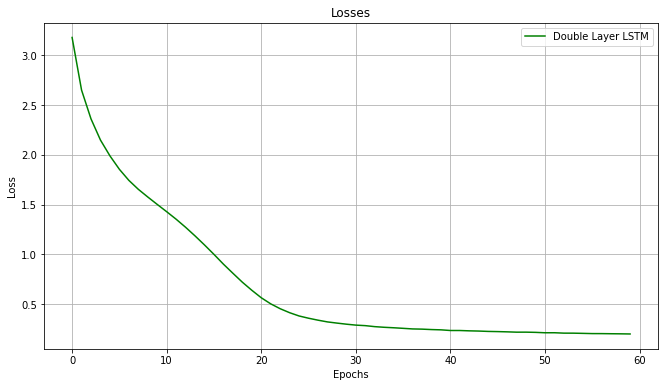

In [27]:
# построим график функции потерь

plt.figure(figsize=[11,6])
plt.plot(lstm_two.history['loss'], 'g')
plt.grid()
plt.title('Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Double Layer LSTM'], loc='upper right')   

# Полносвязная RNN

In [29]:
# полносвязная сеть RNN

rnn = Sequential([
                  Embedding(n_vocab, 256,
                            batch_input_shape=[batch_size, None]),
                  SimpleRNN(1024,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
                  Dense(n_vocab)
                  ])

rnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (64, None, 256)           17408     
_________________________________________________________________
simple_rnn (SimpleRNN)       (64, None, 1024)          1311744   
_________________________________________________________________
dense_2 (Dense)              (64, None, 68)            69700     
Total params: 1,398,852
Trainable params: 1,398,852
Non-trainable params: 0
_________________________________________________________________


In [30]:
# cкомпилируем модель

rnn.compile(loss= loss, optimizer='adam')

In [31]:
# создадим чекпоинты

rnn_dir = './rnn_checkpoints'
rnn_prefix = os.path.join(rnn_dir, "checkpoint_{epoch}")
rnn_checkpoint = ModelCheckpoint(filepath=rnn_prefix, save_weights_only=True)

In [32]:
# обучим модель

RNN = rnn.fit(data, epochs=num_epochs,callbacks=[rnn_checkpoint])

Epoch 1/60
76/76 [==============================] - 9s 120ms/step - loss: 3.0690
Epoch 2/60
76/76 [==============================] - 9s 118ms/step - loss: 2.6421
Epoch 3/60
76/76 [==============================] - 9s 118ms/step - loss: 2.3959
Epoch 4/60
76/76 [==============================] - 9s 119ms/step - loss: 2.2892
Epoch 5/60
76/76 [==============================] - 9s 118ms/step - loss: 2.2047
Epoch 6/60
76/76 [==============================] - 9s 119ms/step - loss: 2.1266
Epoch 7/60
76/76 [==============================] - 9s 118ms/step - loss: 2.0572
Epoch 8/60
76/76 [==============================] - 9s 118ms/step - loss: 1.9980
Epoch 9/60
76/76 [==============================] - 9s 118ms/step - loss: 1.9422
Epoch 10/60
76/76 [==============================] - 9s 119ms/step - loss: 1.8888
Epoch 11/60
76/76 [==============================] - 9s 119ms/step - loss: 1.8443
Epoch 12/60
76/76 [==============================] - 9s 119ms/step - loss: 1.8035
Epoch 13/60
76/76 [======

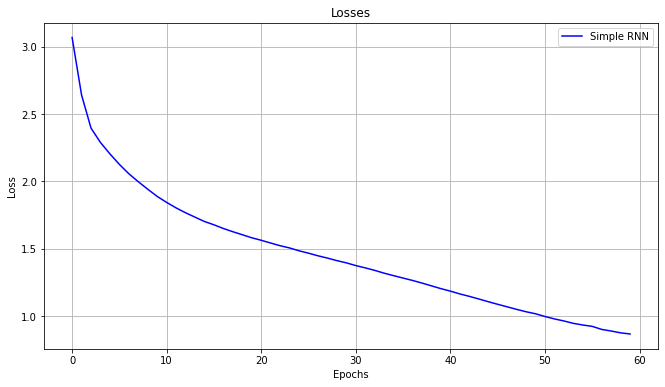

In [33]:
# построим график функции потерь

plt.figure(figsize=[11,6])
plt.plot(RNN.history['loss'], 'b')
plt.grid()
plt.title('Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Simple RNN'], loc='upper right')   

# Однослойная GRU

In [34]:
# однослойная сеть GRU

gru_sing = Sequential([
                  Embedding(n_vocab, 256,
                            batch_input_shape=[batch_size, None]),
                  GRU(1024,
                      return_sequences=True,
                      stateful=True,
                      recurrent_initializer='glorot_uniform'),
                  Dense(n_vocab)
                  ])

gru_sing.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (64, None, 256)           17408     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense_3 (Dense)              (64, None, 68)            69700     
Total params: 4,025,412
Trainable params: 4,025,412
Non-trainable params: 0
_________________________________________________________________


In [35]:
# cкомпилируем модель

gru_sing.compile(loss= loss, optimizer='adam')

In [36]:
# создадим чекпоинты

gru_sing_dir = './gru1_checkpoints'
gru_sing_prefix = os.path.join(gru_sing_dir, "checkpoint_{epoch}")
gru_sing_checkpoint = ModelCheckpoint(filepath=gru_sing_prefix, save_weights_only=True)

In [37]:
# обучим модель

gru1 = gru_sing.fit(data, epochs=num_epochs,callbacks=[gru_sing_checkpoint])

Epoch 1/60
76/76 [==============================] - 10s 135ms/step - loss: 3.2426
Epoch 2/60
76/76 [==============================] - 10s 134ms/step - loss: 2.4927
Epoch 3/60
76/76 [==============================] - 10s 134ms/step - loss: 2.3194
Epoch 4/60
76/76 [==============================] - 10s 133ms/step - loss: 2.1645
Epoch 5/60
76/76 [==============================] - 10s 133ms/step - loss: 2.0377
Epoch 6/60
76/76 [==============================] - 10s 133ms/step - loss: 1.9334
Epoch 7/60
76/76 [==============================] - 10s 134ms/step - loss: 1.8408
Epoch 8/60
76/76 [==============================] - 10s 133ms/step - loss: 1.7632
Epoch 9/60
76/76 [==============================] - 10s 133ms/step - loss: 1.6950
Epoch 10/60
76/76 [==============================] - 10s 133ms/step - loss: 1.6332
Epoch 11/60
76/76 [==============================] - 10s 133ms/step - loss: 1.5788
Epoch 12/60
76/76 [==============================] - 10s 133ms/step - loss: 1.5270
Epoch 13/60
7

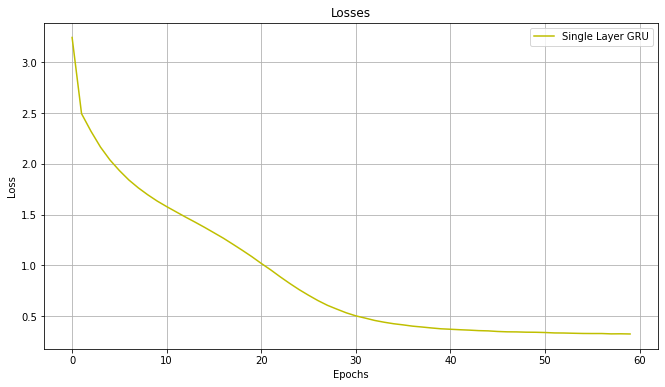

In [40]:
# построим график функции потерь

plt.figure(figsize=[11,6])
plt.plot(gru1.history['loss'],'y')
plt.grid()
plt.title('Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Single Layer GRU'], loc='upper right')   

# Сравнение архитектур

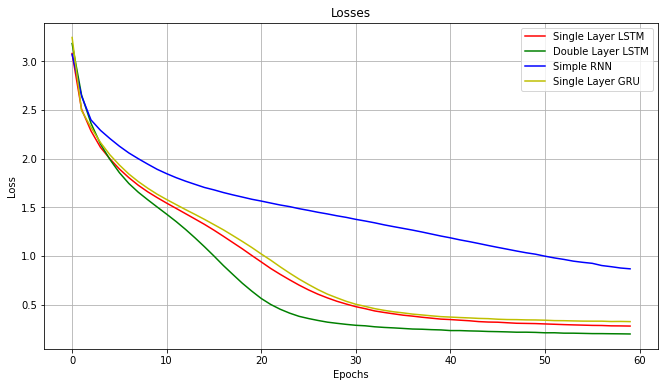

In [41]:
plt.figure(figsize=[11,6])

plt.plot(lstm_one.history['loss'], 'r')
plt.plot(lstm_two.history['loss'], 'g')
plt.plot(RNN.history['loss'], 'b')
plt.plot(gru1.history['loss'],'y')

plt.grid()
plt.title('Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Single Layer LSTM','Double Layer LSTM', 'Simple RNN', 'Single Layer GRU' ], loc='upper right')   

# Генерация текста

In [42]:
# модели нужно перестроить с batch_size = 1

# односйлойная сеть LSTM 

lstm_sing =  Sequential([
                         Embedding(n_vocab, 256,
                                   batch_input_shape=[1, None]),
                         LSTM(1024,
                              return_sequences=True,
                              stateful=True,
                              recurrent_initializer='glorot_uniform'),
                         Dense(n_vocab)
                         ])

# загрузим веса из полседнего чекпоинта 

lstm_sing.load_weights(tf.train.latest_checkpoint(lstm_sing_dir))

# построим модель

lstm_sing.build(tf.TensorShape([1, None]))

In [43]:
# двухслойная сеть LSTM 

lstm_double =  Sequential([
                         Embedding(n_vocab, 256,
                                   batch_input_shape=[1, None]),
                         LSTM(1024,
                              return_sequences=True,
                              stateful=True,
                              recurrent_initializer='glorot_uniform'),
                         LSTM(1024,
                              return_sequences=True,
                              stateful=True,
                              recurrent_initializer='glorot_uniform'),
                         Dense(n_vocab)
                         ])

# загрузим веса из полседнего чекпоинта 

lstm_double.load_weights(tf.train.latest_checkpoint(lstm_double_dir))

# построим модель

lstm_double.build(tf.TensorShape([1, None]))

In [44]:
# полносвязная сеть RNN

rnn = Sequential([
                  Embedding(n_vocab, 256,
                            batch_input_shape=[1, None]),
                  SimpleRNN(1024,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
                  Dense(n_vocab)
                  ])

# загрузим веса из полседнего чекпоинта 

rnn.load_weights(tf.train.latest_checkpoint(rnn_dir))

# построим модель

rnn.build(tf.TensorShape([1, None]))

In [45]:
# однослойная сеть GRU

gru_sing = Sequential([
                  Embedding(n_vocab, 256,
                            batch_input_shape=[1, None]),
                  GRU(1024,
                      return_sequences=True,
                      stateful=True,
                      recurrent_initializer='glorot_uniform'),
                  Dense(n_vocab)
                  ])


gru_sing.load_weights(tf.train.latest_checkpoint(gru_sing_dir))

# построим модель

gru_sing.build(tf.TensorShape([1, None]))

In [51]:
# функция генерации текста

def generate_text(model, start_string, num_generate):
  # Evaluation step (generating text using the learned model)

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return start_string + list_to_text(text_generated)

In [75]:
print(generate_text(lstm_sing, 'ранним утром', 100))

ранним утром петр прибежали к тебе,
в городе в низу заговорила - ухмылким мотала рукой
пряслины! - в заулок орет


In [83]:
print(generate_text(lstm_double, 'ранним утром', 100))

ранним утром вором орать.
     наконец по лестнице с зажженным фонарем михаил начал спускаться в  одну  коровенк


In [79]:
print(generate_text(rnn, 'ранним утром', 100))

ранним утром и волючой братья, и к сену воз у  михаила  из кон, - это горят, всех пол,  что  расческве
ивановна 


In [82]:
print(generate_text(gru_sing, 'ранним утром', 100))

ранним утром отвернулась от меня... пришлось  бежать  за
помощникам приехал? поком  он  впол всем заил. -
узнал 
